# BART Ridership Analysis & Stations, Routes, and Peak Patterns

<img src="https://upload.wikimedia.org/wikipedia/commons/2/29/BART_train_from_Farallones_Street_footbridge_%281%29%2C_July_2023.JPG">

## 🎯  Project Objective  
The goal of this project is to analyze Bay Area Rapid Transit (BART) ridership patterns using hourly
origin–destination trip counts from **2016 and 2017**. The analysis focuses on understanding when and where
BART demand is highest, which routes are underutilized, and what travel times are more likely to offer a seat.

This notebook is organized as a complete data workflow:
- 📂 Understand the dataset structure and key columns  
- ⚙️ Prepare the data by appending and merging files  
- 📊 Answer analytics questions about stations, routes, time-of-day, and day-of-week patterns  
- 📏 Compute station-to-station straight-line distances  
- 🤖 Propose a data science approach to predict commuting demand between any two stations  

**Key Deliverables**
- Busiest station and busiest weekday  
- Least popular route (origin → destination)  
- Best hour to travel from Berkeley to San Francisco to maximize the chance of finding a seat  
- Late-night ridership total  
- Distance features and a modeling plan for demand prediction

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## 📂 Dataset Description

This project uses hourly BART ridership data describing passenger flows
between origin and destination stations in the San Francisco Bay Area.

### Ridership Data (2016–2017)

Two CSV files (`2016` and `2017`) contain hourly counts of trips between
station pairs.

**Main columns:**
- `Origin`, `Destination` : station abbreviations  
- `Throughput` : number of passenger trips  
- `DateTime` : date and hour of travel  

The data is recorded at an **hourly level** and represents directional
origin → destination flows.

### Station Metadata

The `station_info.csv` file provides station names and geographic coordinates.

**Main columns:**
- `Abbreviation` : station code  
- `Name` : full station name  
- `Location` : latitude and longitude  

This metadata enables readable station labels and distance-based analysis.

### Final Dataset

The 2016 and 2017 ridership files are appended into a single dataset and
merged with station metadata for both origin and destination stations.
The resulting dataset supports temporal, route-level, and spatial analysis.

In [2]:
r16 = pd.read_csv("/kaggle/input/bart-ridership/date-hour-soo-dest-2016.csv")
r17 = pd.read_csv("/kaggle/input/bart-ridership/date-hour-soo-dest-2017.csv")
stations = pd.read_csv("/kaggle/input/bart-ridership/station_info.csv")

In [3]:
r16.head()

,Origin,Destination,Throughput,DateTime
0,12TH,12TH,1,2016-01-01 00:00:00
1,12TH,16TH,1,2016-01-01 00:00:00
2,12TH,24TH,4,2016-01-01 00:00:00
3,12TH,ASHB,4,2016-01-01 00:00:00
4,12TH,BALB,2,2016-01-01 00:00:00


In [4]:
r17.head()

,Origin,Destination,Throughput,DateTime
0,12TH,19TH,1,2017-01-01 00:00:00
1,12TH,24TH,2,2017-01-01 00:00:00
2,12TH,BAYF,1,2017-01-01 00:00:00
3,12TH,CIVC,5,2017-01-01 00:00:00
4,12TH,COLS,2,2017-01-01 00:00:00


In [5]:
stations.head()

,Abbreviation,Description,Location,Name
0,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH)
1,16TH,"2000 Mission Street, San Francisco CA 94110<br...","-122.419694,37.765062,0",16th St. Mission (16TH)
2,19TH,"1900 Broadway, Oakland CA 94612<br />19th Stre...","-122.268602,37.808350,0",19th St. Oakland (19TH)
3,24TH,"2800 Mission Street, San Francisco CA 94110<br...","-122.418143,37.752470,0",24th St. Mission (24TH)
4,ASHB,"3100 Adeline Street, Berkeley CA 94703<br />As...","-122.270062,37.852803,0",Ashby (ASHB)


In [6]:
df = pd.concat([r16, r17], ignore_index=True)

In [7]:
df.head()

,Origin,Destination,Throughput,DateTime
0,12TH,12TH,1,2016-01-01 00:00:00
1,12TH,16TH,1,2016-01-01 00:00:00
2,12TH,24TH,4,2016-01-01 00:00:00
3,12TH,ASHB,4,2016-01-01 00:00:00
4,12TH,BALB,2,2016-01-01 00:00:00


In [8]:
df.tail()

,Origin,Destination,Throughput,DateTime
13285202,WSPR,MONT,1,2017-05-03 23:00:00
13285203,WSPR,NBRK,1,2017-05-03 23:00:00
13285204,WSPR,NCON,1,2017-05-03 23:00:00
13285205,WSPR,SANL,2,2017-05-03 23:00:00
13285206,WSPR,SHAY,4,2017-05-03 23:00:00


In [9]:
df.shape

(13285207, 4)

In [10]:
df.sample()

,Origin,Destination,Throughput,DateTime
11246191,EMBR,SSAN,1,2017-02-18 01:00:00


In [11]:
df.isnull().sum()

Origin         0
Destination    0
Throughput     0
DateTime       0
dtype: int64

### ⚙️ Data Preprocessing

After completing all preprocessing steps, we obtain a single clean dataset
ready for analysis.

The final dataframe contains:
- Original ridership information (origin, destination, throughput, datetime)
- Parsed temporal features:
  - `hour` (0–23)
  - `day` (day of the week)
- Human-readable station names for both origin and destination
- Geographic coordinates (latitude and longitude) for each station

All rows with missing station metadata were removed to ensure:
- Consistent station-level analysis
- Reliable route comparisons
- Valid distance-based calculations

At this stage, the dataset contains no missing values and is fully prepared
for ridership analysis and modeling.

In [12]:
df["DateTime"] = pd.to_datetime(df["DateTime"])
df["hour"] = df["DateTime"].dt.hour
df["day"]  = df["DateTime"].dt.day_name()

In [ ]:
df = df.dropna(subset=["Origin_Name","Origin_Lat","Origin_Lon"])

In [ ]:
df = df.dropna(subset=["Destination_Name","Dest_Lat","Dest_Lon"])

In [16]:
df.isnull().sum()

Origin         0
Destination    0
Throughput     0
DateTime       0
hour           0
day            0
dtype: int64

In [17]:
stations[["lon","lat","_"]] = stations["Location"].str.split(",", expand=True)
stations[["lon","lat"]] = stations[["lon","lat"]].astype(float)

In [18]:
s = stations[["Abbreviation","Name","lat","lon"]]

df = df.merge(s, left_on="Origin", right_on="Abbreviation", how="left") \
       .rename(columns={"Name":"Origin_Name","lat":"Origin_Lat","lon":"Origin_Lon"}) \
       .drop(columns="Abbreviation")

df = df.merge(s, left_on="Destination", right_on="Abbreviation", how="left") \
       .rename(columns={"Name":"Destination_Name","lat":"Dest_Lat","lon":"Dest_Lon"}) \
       .drop(columns="Abbreviation")

In [19]:
df.head()

,Origin,Destination,Throughput,DateTime,hour,day,Origin_Name,Origin_Lat,Origin_Lon,Destination_Name,Dest_Lat,Dest_Lon
0,12TH,12TH,1,2016-01-01,0,Friday,12th St. Oakland City Center (12TH),37.803768,-122.27145,12th St. Oakland City Center (12TH),37.803768,-122.271450
1,12TH,16TH,1,2016-01-01,0,Friday,12th St. Oakland City Center (12TH),37.803768,-122.27145,16th St. Mission (16TH),37.765062,-122.419694
2,12TH,24TH,4,2016-01-01,0,Friday,12th St. Oakland City Center (12TH),37.803768,-122.27145,24th St. Mission (24TH),37.752470,-122.418143
3,12TH,ASHB,4,2016-01-01,0,Friday,12th St. Oakland City Center (12TH),37.803768,-122.27145,Ashby (ASHB),37.852803,-122.270062
4,12TH,BALB,2,2016-01-01,0,Friday,12th St. Oakland City Center (12TH),37.803768,-122.27145,Balboa Park (BALB),37.721585,-122.447506


## 📊 Ridership Analysis

This section examines BART ridership patterns using aggregated trip counts
and simple time-based filters.

### Analysis Questions

1. **Which BART station is the busiest?**  
2. **What is the least popular BART route?**  
3. **When is the best time to travel from Berkeley to San Francisco to find a seat?**  
4. **Which day of the week is the busiest?**  
5. **How many people use BART late at night?**

The results highlight key demand patterns across stations, routes, and time.

In [20]:
busiest_station = (df.groupby("Origin_Name")["Throughput"].sum().sort_values(ascending=False).head(1))

In [21]:
busiest_station

Origin_Name
Montgomery St. (MONT)    16107314
Name: Throughput, dtype: int64

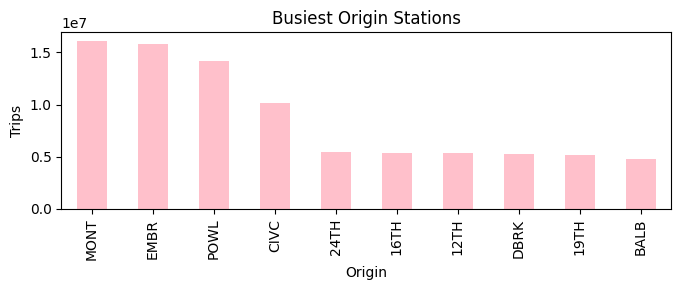

In [24]:
top = df.groupby("Origin")["Throughput"].sum().nlargest(10)

top.plot.bar(color="pink", figsize=(7,3), title="Busiest Origin Stations")
plt.ylabel("Trips")
plt.tight_layout()
plt.show()

In [25]:
least_route = (df.groupby(["Origin_Name","Destination_Name"])["Throughput"].sum().sort_values().head(1))

In [26]:
least_route

Origin_Name                    Destination_Name             
West Dublin/Pleasanton (WDUB)  North Concord/Martinez (NCON)    358
Name: Throughput, dtype: int64

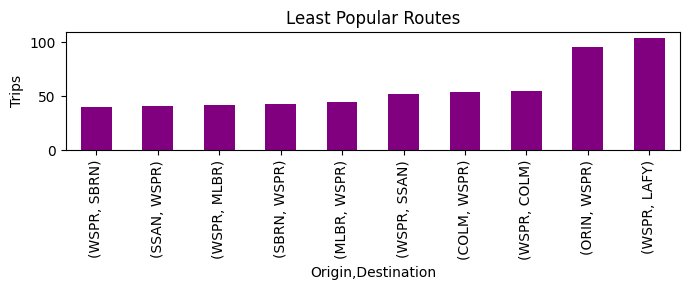

In [29]:
routes.plot.bar(color="purple", figsize=(7,3), title="Least Popular Routes")
plt.ylabel("Trips")
plt.tight_layout()
plt.show()

In [31]:
best_hour = (berkeley_sf.groupby("hour")["Throughput"].sum().sort_values().head(1))

In [32]:
best_hour

hour
3    37
Name: Throughput, dtype: int64

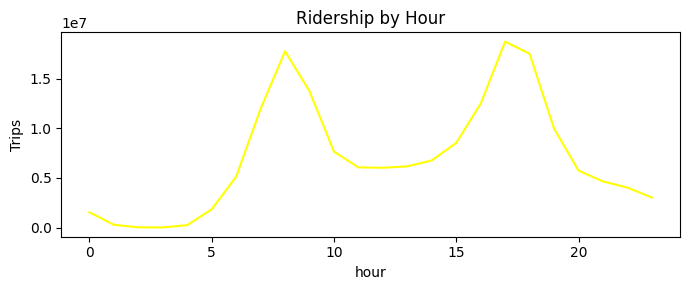

In [33]:
df["hour"] = pd.to_datetime(df["DateTime"]).dt.hour
hourly = df.groupby("hour")["Throughput"].sum()

hourly.plot(color="yellow", figsize=(7,3), title="Ridership by Hour")
plt.ylabel("Trips")
plt.tight_layout()
plt.show();

In [34]:
busiest_day = (df.groupby("day")["Throughput"].sum().sort_values(ascending=False).head(1))

In [35]:
busiest_day

day
Wednesday    30677189
Name: Throughput, dtype: int64

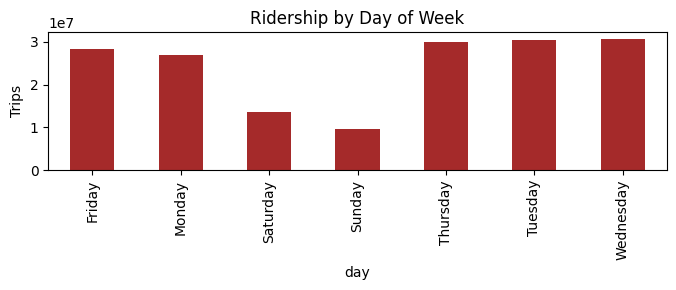

In [36]:
day_totals = df.groupby("day")["Throughput"].sum()

day_totals.plot.bar(color="brown", figsize=(7,3), title="Ridership by Day of Week")
plt.ylabel("Trips")
plt.tight_layout()
plt.show()

In [37]:
late_night = df[df["hour"].isin([22,23,0,1,2,3,4,5])]["Throughput"].sum()

In [38]:
late_night

10965448

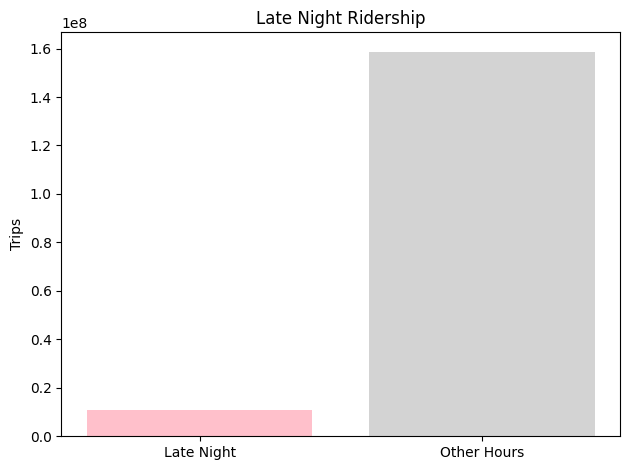

In [39]:
late = df[df["hour"].isin([22,23,0,1,2,3,4,5])]["Throughput"].sum()
other = df[~df["hour"].isin([22,23,0,1,2,3,4,5])]["Throughput"].sum()

plt.bar(["Late Night","Other Hours"], [late, other], color=["pink","lightgray"])
plt.title("Late Night Ridership")
plt.ylabel("Trips")
plt.tight_layout()
plt.show()

## 📏 Station Distance Computation

To support network-style analysis and future modeling, we compute straight-line distances between stations
using latitude and longitude from `station_info.csv`.

We use the **Haversine formula** to calculate great-circle distance (in kilometers).
This provides:
- A distance value for each origin–destination trip record  
- A reusable feature that often correlates with travel demand (longer trips may have different patterns)

Distance features help explain route usage and can strengthen predictive models.


In [40]:
from math import radians, sin, cos, sqrt, atan2

In [41]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

In [42]:
df["distance_km"] = df.apply(lambda x: haversine(x["Origin_Lat"], x["Origin_Lon"],x["Dest_Lat"], x["Dest_Lon"]),axis=1)

In [45]:
df.head()

,Origin,Destination,Throughput,DateTime,hour,day,Origin_Name,Origin_Lat,Origin_Lon,Destination_Name,Dest_Lat,Dest_Lon,distance_km
0,12TH,12TH,1,2016-01-01,0,Friday,12th St. Oakland City Center (12TH),37.803768,-122.27145,12th St. Oakland City Center (12TH),37.803768,-122.271450,0.000000
1,12TH,16TH,1,2016-01-01,0,Friday,12th St. Oakland City Center (12TH),37.803768,-122.27145,16th St. Mission (16TH),37.765062,-122.419694,13.720175
2,12TH,24TH,4,2016-01-01,0,Friday,12th St. Oakland City Center (12TH),37.803768,-122.27145,24th St. Mission (24TH),37.752470,-122.418143,14.097927
3,12TH,ASHB,4,2016-01-01,0,Friday,12th St. Oakland City Center (12TH),37.803768,-122.27145,Ashby (ASHB),37.852803,-122.270062,5.453806
4,12TH,BALB,2,2016-01-01,0,Friday,12th St. Oakland City Center (12TH),37.803768,-122.27145,Balboa Park (BALB),37.721585,-122.447506,17.972899


In [44]:
df["distance_km"].describe()

count    1.325374e+07
mean     2.176626e+01
std      1.317003e+01
min      0.000000e+00
25%      1.211031e+01
50%      1.995644e+01
75%      3.099361e+01
max      6.059397e+01
Name: distance_km, dtype: float64

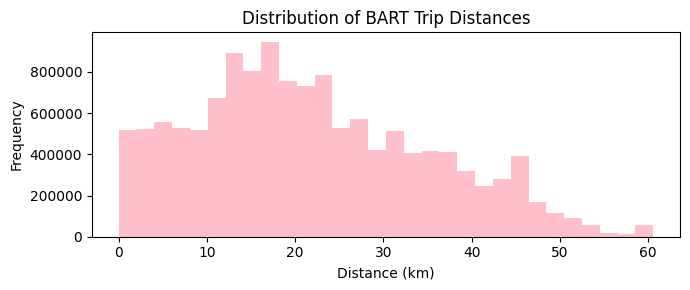

In [46]:
df["distance_km"].plot(kind="hist",bins=30,figsize=(7,3),color="pink",title="Distribution of BART Trip Distances")
plt.xlabel("Distance (km)")
plt.tight_layout()
plt.show()

## 🤖 Demand Modeling Approach

The objective is to predict the number of passenger trips between any
origin–destination station pair.

### Problem formulation
- **Target:** hourly trip count between stations
- **Features:**
  - Time: hour, day of week
  - Stations: origin and destination
  - Distance between stations
  - Optional lag features (recent historical averages)

### Modeling strategy
A baseline linear or ridge regression model can be used initially,
followed by tree-based models (e.g., Random Forest or Gradient Boosting)
to capture non-linear demand patterns.  
Model evaluation should follow a time-based train–validation split
to avoid temporal leakage.

### Potential applications
Such a model could support service planning by improving demand forecasts,
reducing overcrowding on busy routes, and guiding long-term infrastructure decisions.

In [49]:
model_df = df[["DateTime","hour","day","Origin","Destination","distance_km","Throughput"]].dropna()

In [50]:
model_df = model_df.sort_values("DateTime")

In [51]:
model_df.head()

,DateTime,hour,day,Origin,Destination,distance_km,Throughput
0,2016-01-01,0,Friday,12TH,12TH,0.000000,1
523,2016-01-01,0,Friday,MONT,MCAR,12.572993,52
524,2016-01-01,0,Friday,MONT,MLBR,21.068682,11
525,2016-01-01,0,Friday,MONT,MONT,0.000000,18
526,2016-01-01,0,Friday,MONT,NBRK,13.968877,16


In [52]:
model_df = model_df[model_df["Origin"] != model_df["Destination"]]

In [53]:
model_df = model_df.drop(columns="DateTime")

In [54]:
cut = int(len(model_df) * 0.8)
train = model_df.iloc[:cut]
test  = model_df.iloc[cut:]

In [55]:
x_train = train[["hour","day","Origin","Destination","distance_km"]]

In [56]:
y_train = train["Throughput"]

In [57]:
x_test  = test[["hour","day","Origin","Destination","distance_km"]]

In [58]:
y_test  = test["Throughput"]

In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [72]:
cat_cols = ["day","Origin","Destination"]

In [73]:
num_cols = ["hour","distance_km"]

In [74]:
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)])

In [75]:
model = Pipeline([("prep", preprocess),("model", LinearRegression())])

In [76]:
model.fit(x_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['day', 'Origin',
                                                   'Destination']),
                                                 ('num', 'passthrough',
                                                  ['hour', 'distance_km'])])),
                ('model', LinearRegression())])

In [78]:
pred = model.predict(x_test)

In [79]:
mean_absolute_error(y_test, pred)

12.713677432884197

In [82]:
mean_squared_error(y_test, pred, squared=False)

30.612086672817032

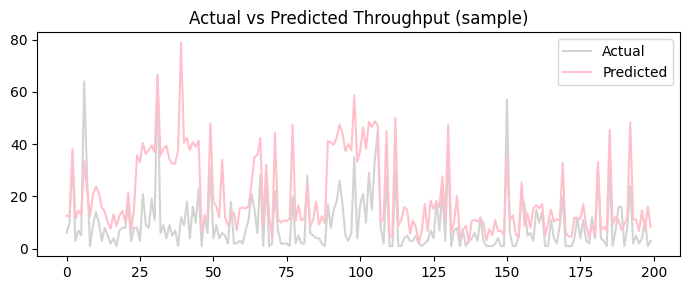

In [81]:
plt.figure(figsize=(7,3))
plt.plot(y_test.values[:200], label="Actual", color="lightgray")
plt.plot(pred[:200], label="Predicted", color="pink")
plt.title("Actual vs Predicted Throughput (sample)")
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

In this project, BART ridership data from 2016–2017 was analyzed to uncover key
demand patterns across stations, routes, and time periods.

The analysis identified the busiest stations, underutilized routes, optimal
travel times, and late-night ridership behavior. In addition, distance-based
features were engineered to support a baseline demand prediction model.

Overall, this project demonstrates how real-world transit data can be transformed
into actionable insights for data-driven transportation planning and operational
decision-making.